In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
#import mplcursors
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

plt.style.use('seaborn-darkgrid')
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
#import tensorflow as tf



In [2]:
import pandas as pd 
pseGDP = pd.read_csv('COVID_PSchExpGDP.csv',index_col = 0)
pseGDP

,State,cases,deaths,Public School Expenditure 2016(Thousands),State GDP(Millions),School Expenditures per State GDP(Percent)
0,Alabama,387786,14345,6885677.0,203398.0,3.385322
1,Alaska,18316,367,2319662.0,49429.0,4.692917
2,Arizona,426614,18857,8551673.0,311397.0,2.746228
3,Arkansas,161569,3301,4872214.0,120090.0,4.057135
4,California,2664110,102387,72003129.0,2663396.0,2.703433
5,Colorado,766512,37828,8648369.0,329097.0,2.627909
6,Connecticut,1314995,104185,10551327.0,262979.0,4.012232
7,Delaware,234327,7813,1941408.0,70380.0,2.758465
8,District of Columbia,229466,10822,1775833.0,129817.0,1.367951
9,Florida,1726811,63147,25621239.0,938370.0,2.730398


In [8]:
pseGDP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 6 columns):
State                                         51 non-null object
cases                                         51 non-null int64
deaths                                        51 non-null int64
Public School Expenditure 2016(Thousands)     51 non-null float64
State GDP(Millions)                           51 non-null float64
School Expenditures per State GDP(Percent)    51 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ KB


In [9]:
pseGDP.isnull().sum()

State                                         0
cases                                         0
deaths                                        0
Public School Expenditure 2016(Thousands)     0
State GDP(Millions)                           0
School Expenditures per State GDP(Percent)    0
dtype: int64

In [10]:
pseGDP.count()

State                                         51
cases                                         51
deaths                                        51
Public School Expenditure 2016(Thousands)     51
State GDP(Millions)                           51
School Expenditures per State GDP(Percent)    51
dtype: int64

In [11]:
pseGDP.describe()

,cases,deaths,Public School Expenditure 2016(Thousands),State GDP(Millions),School Expenditures per State GDP(Percent)
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,51.000000
mean,1.056306e+06,5.861198e+04,1.168893e+07,3.645945e+05,3.342231
std,2.249183e+06,1.579360e+05,1.437929e+07,4.666834e+05,0.679103
min,1.831600e+04,2.810000e+02,1.253268e+06,3.163500e+04,1.367951
25%,1.696980e+05,4.021000e+03,3.001788e+06,8.843550e+04,2.887175
50%,3.877860e+05,1.425100e+04,6.885677e+06,2.126750e+05,3.242778
75%,1.047118e+06,5.046050e+04,1.312050e+07,4.915630e+05,3.630329
max,1.504181e+07,1.081194e+06,7.200313e+07,2.663396e+06,5.283493


In [12]:
corr = pseGDP.corr()
corr

,cases,deaths,Public School Expenditure 2016(Thousands),State GDP(Millions),School Expenditures per State GDP(Percent)
cases,1.000000,0.990033,0.692779,0.569241,0.136192
deaths,0.990033,1.000000,0.612841,0.483295,0.157726
Public School Expenditure 2016(Thousands),0.692779,0.612841,1.000000,0.980652,-0.059501
State GDP(Millions),0.569241,0.483295,0.980652,1.000000,-0.159844
School Expenditures per State GDP(Percent),0.136192,0.157726,-0.059501,-0.159844,1.000000


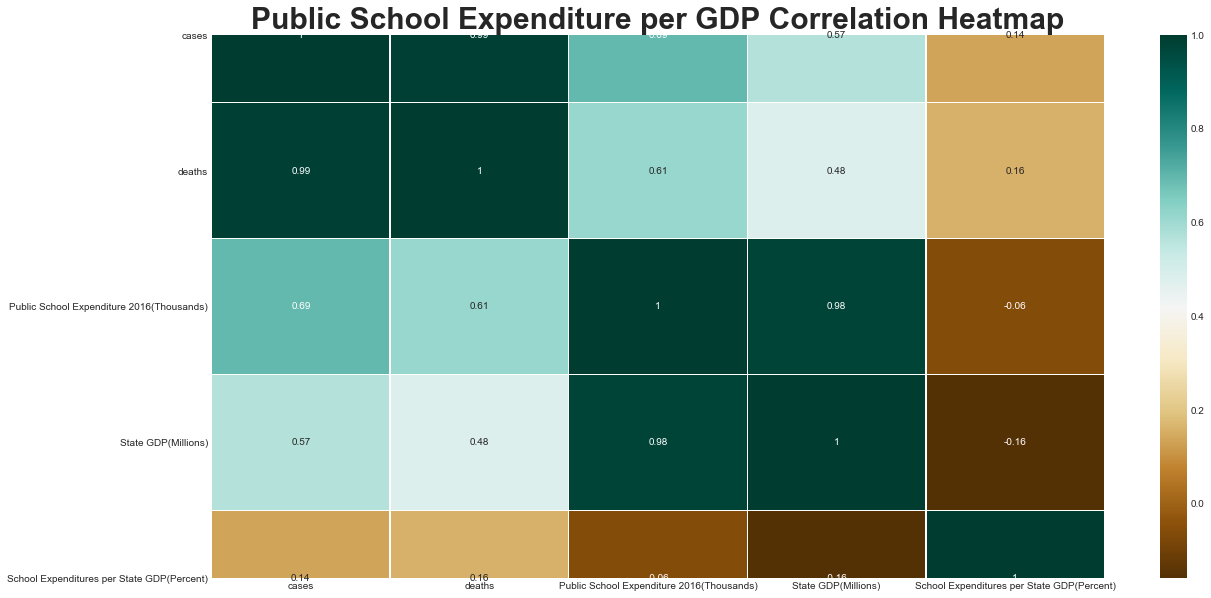

In [18]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap = 'BrBG', annot = True, linewidths = 0.5)
plt.title('Public School Expenditure per GDP Correlation Heatmap', fontweight = 'bold', fontsize = 30);

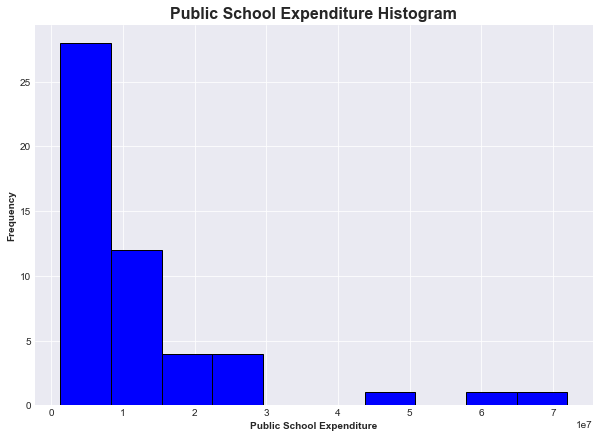

In [19]:
plt.style.use('seaborn-darkgrid')

pseGDP['Public School Expenditure 2016(Thousands)'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Public School Expenditure Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Public School Expenditure', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

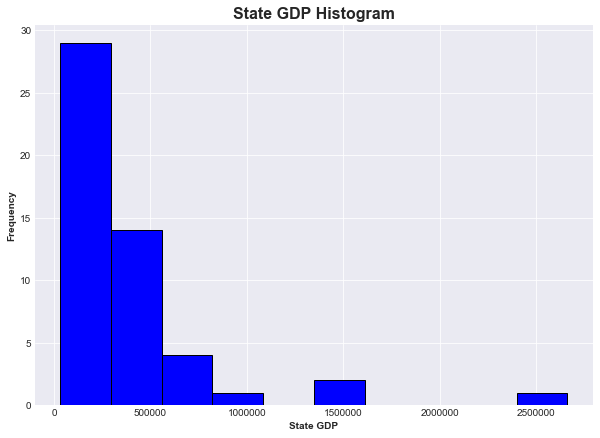

In [20]:
plt.style.use('seaborn-darkgrid')

pseGDP['State GDP(Millions)'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('State GDP Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('State GDP', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

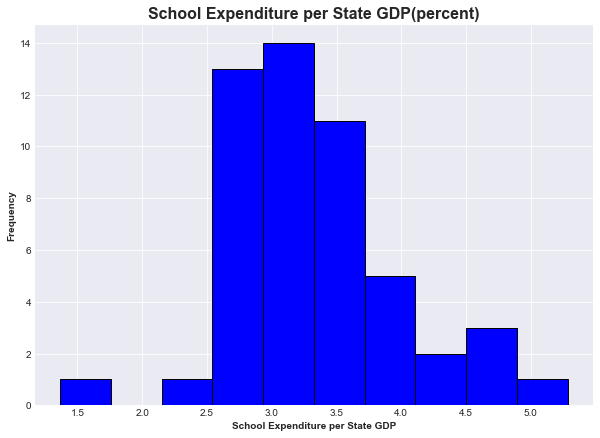

In [21]:
plt.style.use('seaborn-darkgrid')

pseGDP['School Expenditures per State GDP(Percent)'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('School Expenditure per State GDP(percent)', fontsize = 16, fontweight = 'bold')
plt.xlabel('School Expenditure per State GDP', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

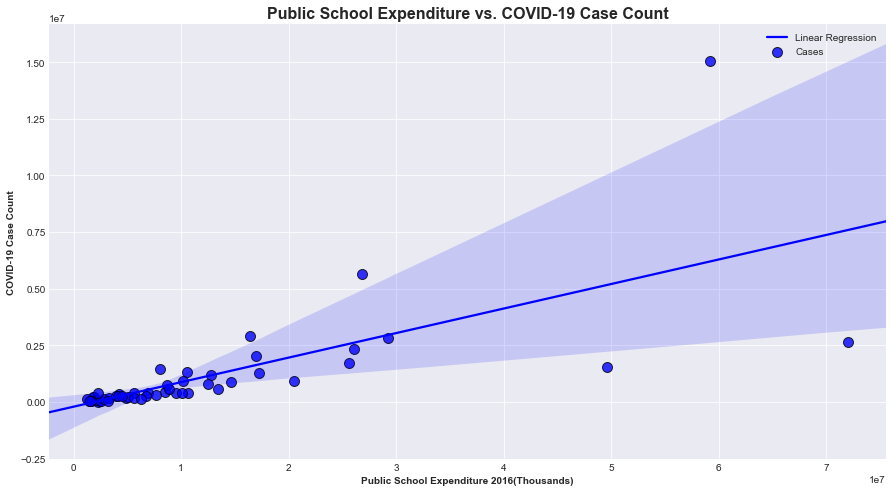

In [22]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Public School Expenditure 2016(Thousands)', y = 'cases', data = pseGDP, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Public School Expenditure vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Public School Expenditure 2016(Thousands)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [23]:
model1 = sm.OLS(pseGDP['cases'], pseGDP['Public School Expenditure 2016(Thousands)']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.571
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              66.58
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    9.43e-11
Time:                        17:19:41   Log-Likelihood:                         -801.38
No. Observations:                  51   AIC:                                      1605.
Df Residuals:                      50   BIC:                                      1607.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Public School Expenditure 2016(Thousands)     0.1011      0.012      8.160      0.000       0.076       0.126
==============================================================================
Omnibus:                       67.299   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              905.076
Skew:                           3.183   Prob(JB):                    2.92e-197
Kurtosis:                      22.631   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

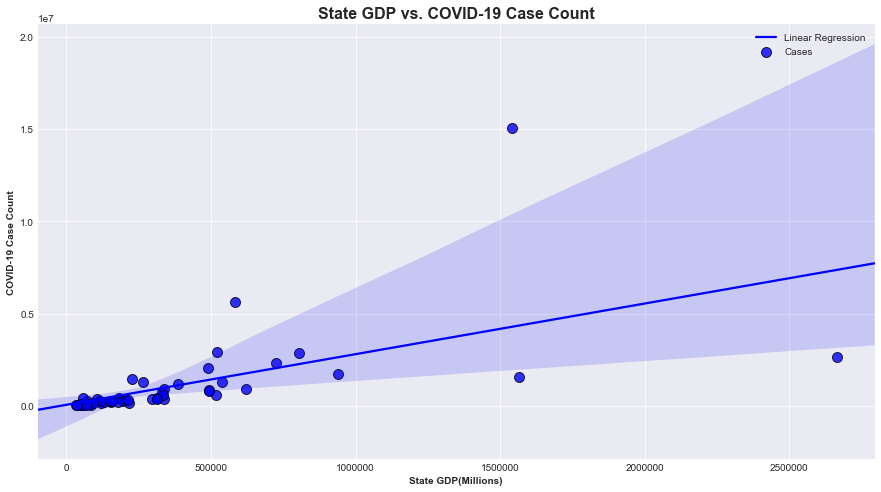

In [24]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'State GDP(Millions)', y = 'cases', data = pseGDP, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('State GDP vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('State GDP(Millions)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])


plt.show();

In [25]:
model2 = sm.OLS(pseGDP['cases'], pseGDP['State GDP(Millions)']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.448
Model:                            OLS   Adj. R-squared (uncentered):              0.437
Method:                 Least Squares   F-statistic:                              40.56
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    5.84e-08
Time:                        17:19:56   Log-Likelihood:                         -807.82
No. Observations:                  51   AIC:                                      1618.
Df Residuals:                      50   BIC:                                      1620.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
State GDP(Millions)     2.8025      0.440      6.368      0.000       1.919       3.686
==============================================================================
Omnibus:                       73.859   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1075.549
Skew:                           3.665   Prob(JB):                    2.80e-234
Kurtosis:                      24.270   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

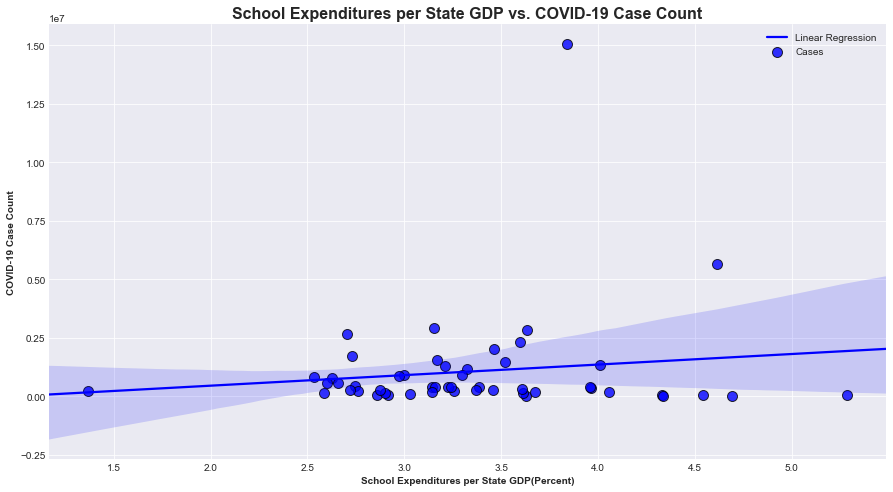

In [26]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'School Expenditures per State GDP(Percent)', y = 'cases', data = pseGDP, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('School Expenditures per State GDP vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('School Expenditures per State GDP(Percent)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [27]:
model3 = sm.OLS(pseGDP['cases'], pseGDP['School Expenditures per State GDP(Percent)']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.197
Model:                            OLS   Adj. R-squared (uncentered):              0.181
Method:                 Least Squares   F-statistic:                              12.30
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    0.000965
Time:                        17:20:08   Log-Likelihood:                         -817.35
No. Observations:                  51   AIC:                                      1637.
Df Residuals:                      50   BIC:                                      1639.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
School Expenditures per State GDP(Percent)  3.213e+05   9.16e+04      3.508      0.001    1.37e+05    5.05e+05
==============================================================================
Omnibus:                       90.295   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1809.033
Skew:                           4.934   Prob(JB):                         0.00
Kurtosis:                      30.458   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
model4 = sm.OLS(pseGDP['cases'], pseGDP[['Public School Expenditure 2016(Thousands)', 'State GDP(Millions)', 'School Expenditures per State GDP(Percent)']]).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.839
Model:                            OLS   Adj. R-squared (uncentered):              0.829
Method:                 Least Squares   F-statistic:                              83.45
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    4.67e-19
Time:                        17:20:17   Log-Likelihood:                         -776.38
No. Observations:                  51   AIC:                                      1559.
Df Residuals:                      48   BIC:                                      1565.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Public School Expenditure 2016(Thousands)      0.5663      0.053     10.742      0.000       0.460       0.672
State GDP(Millions)                          -14.3257      1.604     -8.932      0.000     -17.550     -11.101
School Expenditures per State GDP(Percent) -1.137e+05    5.4e+04     -2.107      0.040   -2.22e+05   -5182.662
==============================================================================
Omnibus:                       17.725   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.486
Skew:                           0.067   Prob(JB):                     2.27e-25
Kurtosis:                      10.307   Cond. No.                     6.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

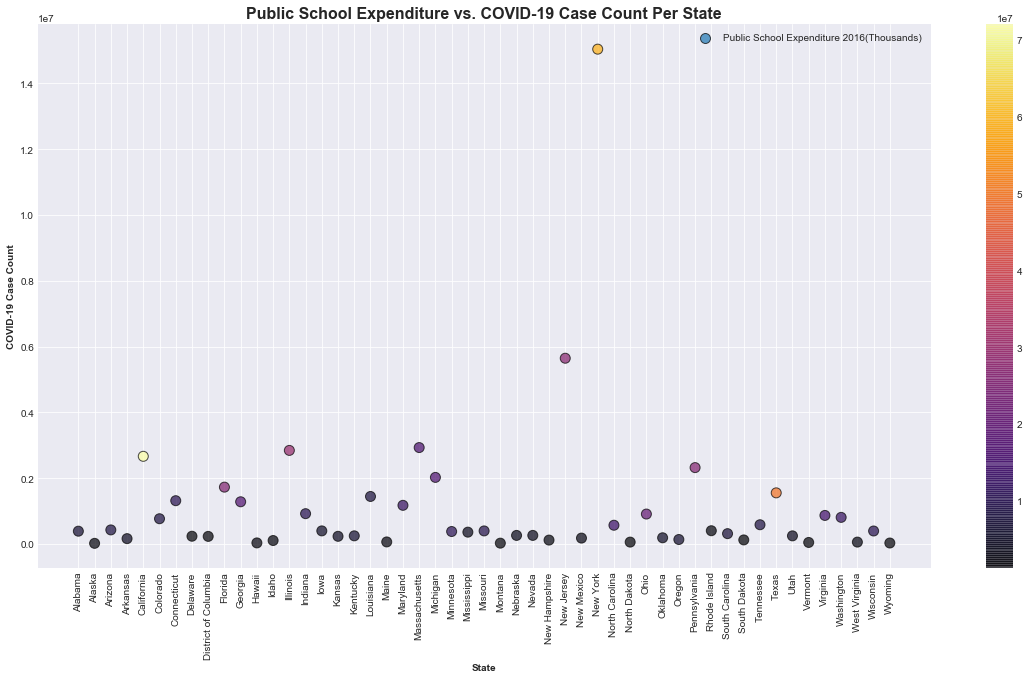

In [29]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = pseGDP['State'] 
y = pseGDP['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = pseGDP['Public School Expenditure 2016(Thousands)'], cmap = 'inferno')
plt.title('Public School Expenditure vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Public School Expenditure 2016(Thousands)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

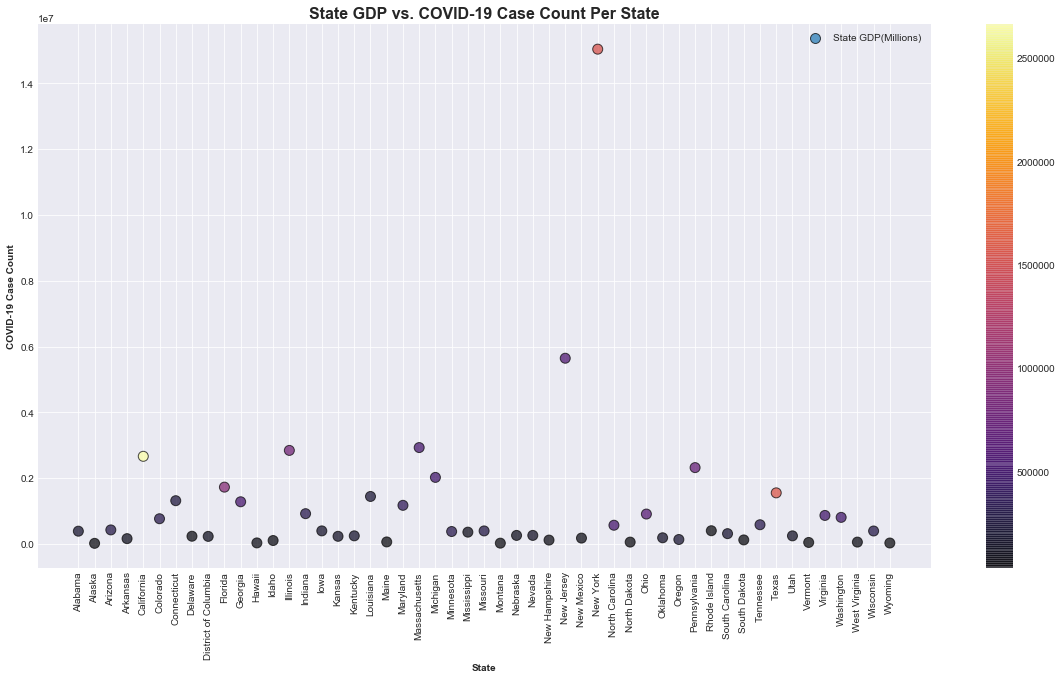

In [30]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = pseGDP['State'] 
y = pseGDP['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = pseGDP['State GDP(Millions)'], cmap = 'inferno')
plt.title('State GDP vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['State GDP(Millions)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

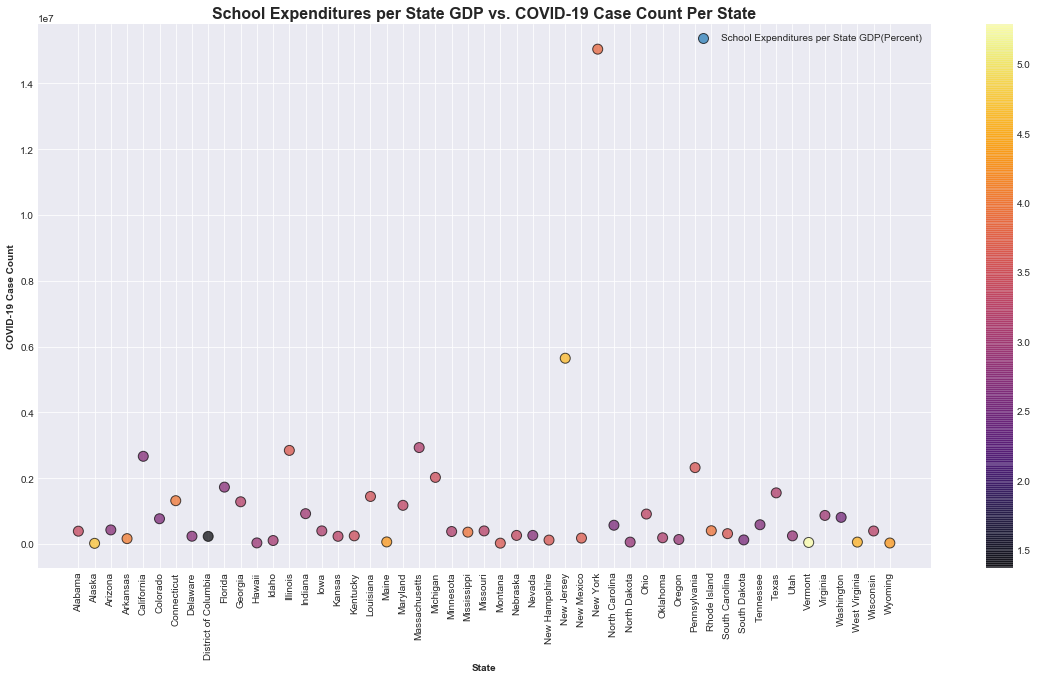

In [31]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = pseGDP['State'] 
y = pseGDP['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = pseGDP['School Expenditures per State GDP(Percent)'], cmap = 'inferno')
plt.title('School Expenditures per State GDP vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['School Expenditures per State GDP(Percent)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

In [3]:
test_len = int(0.25 * len(pseGDP))
train_len = len(pseGDP) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = pseGDP[:train_len]
test = pseGDP[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 6)
Test Set Shape: (12, 6)


In [4]:
features_list = ['Public School Expenditure 2016(Thousands)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 12799499749085.75
MSE Value: 3.741811067698153e+26
RMS Value: 19343761443158.24
R2 Score: -2035090765274073.8


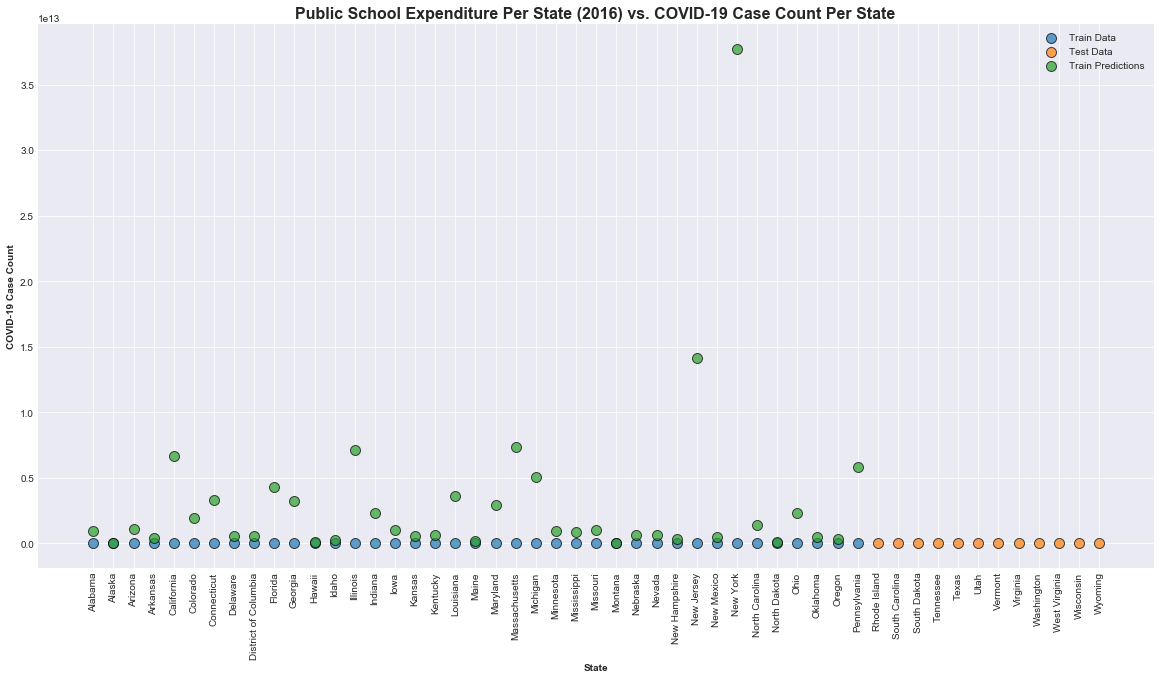

In [5]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Expenditure Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

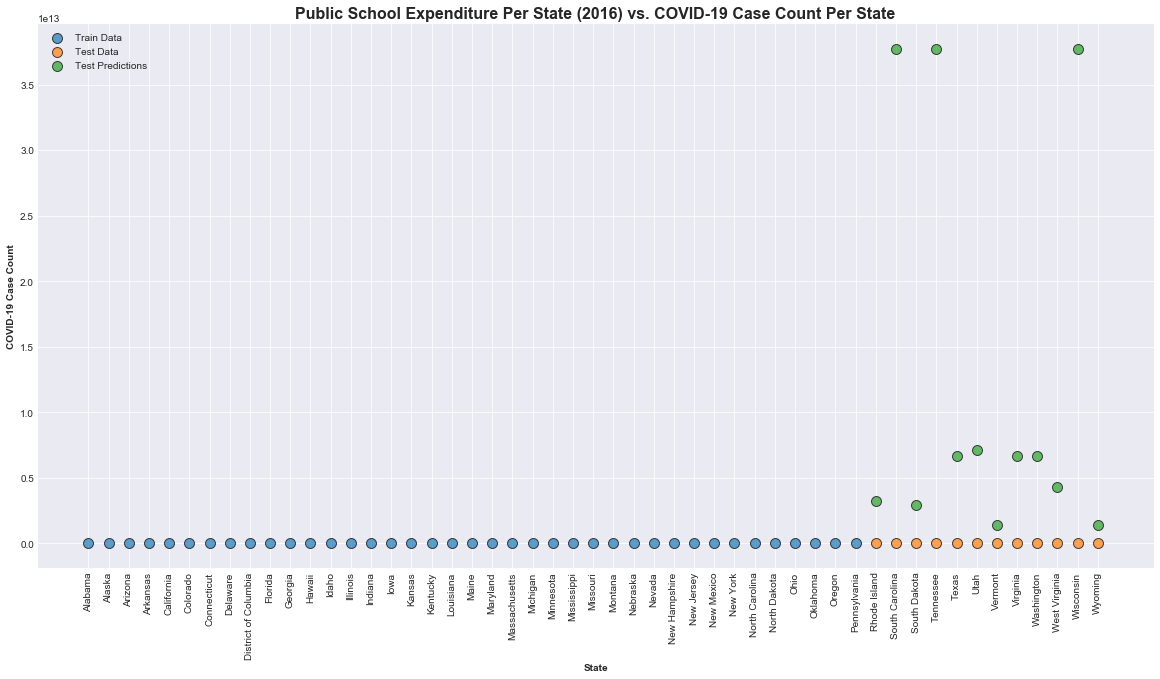

In [6]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Public School Expenditure Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [7]:
features_list = ['State GDP(Millions)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 1568367552221.75
MSE Value: 4.741169123144935e+24
RMS Value: 2177422587176.1628
R2 Score: -25786201720361.19


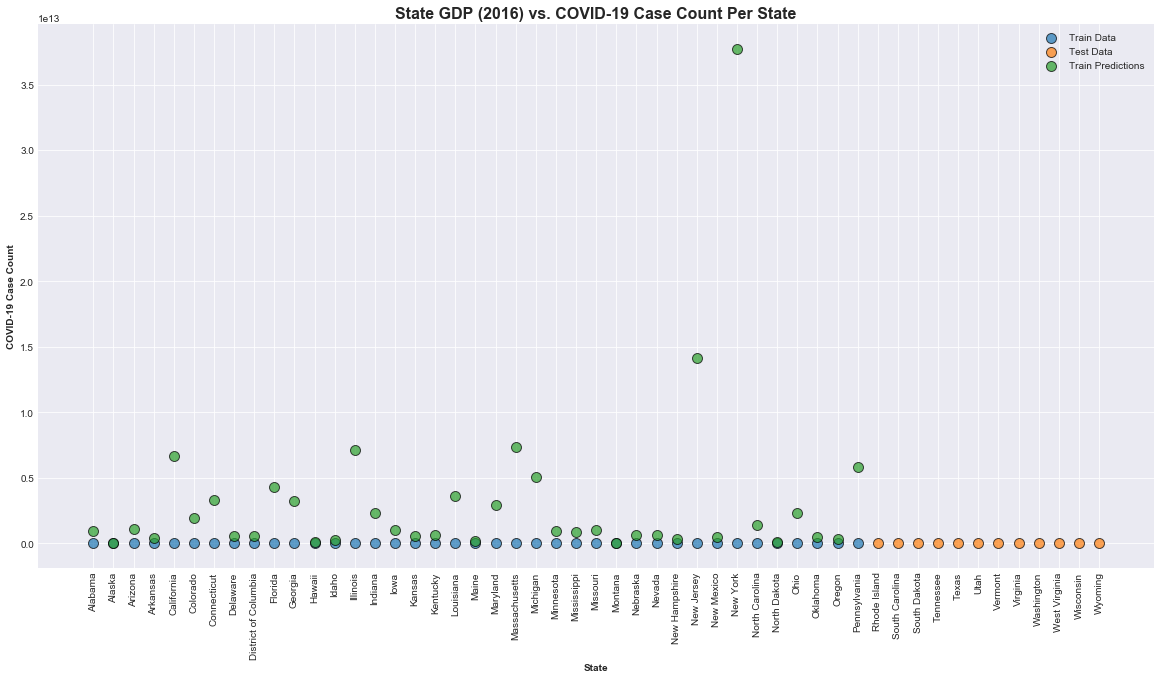

In [8]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('State GDP (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

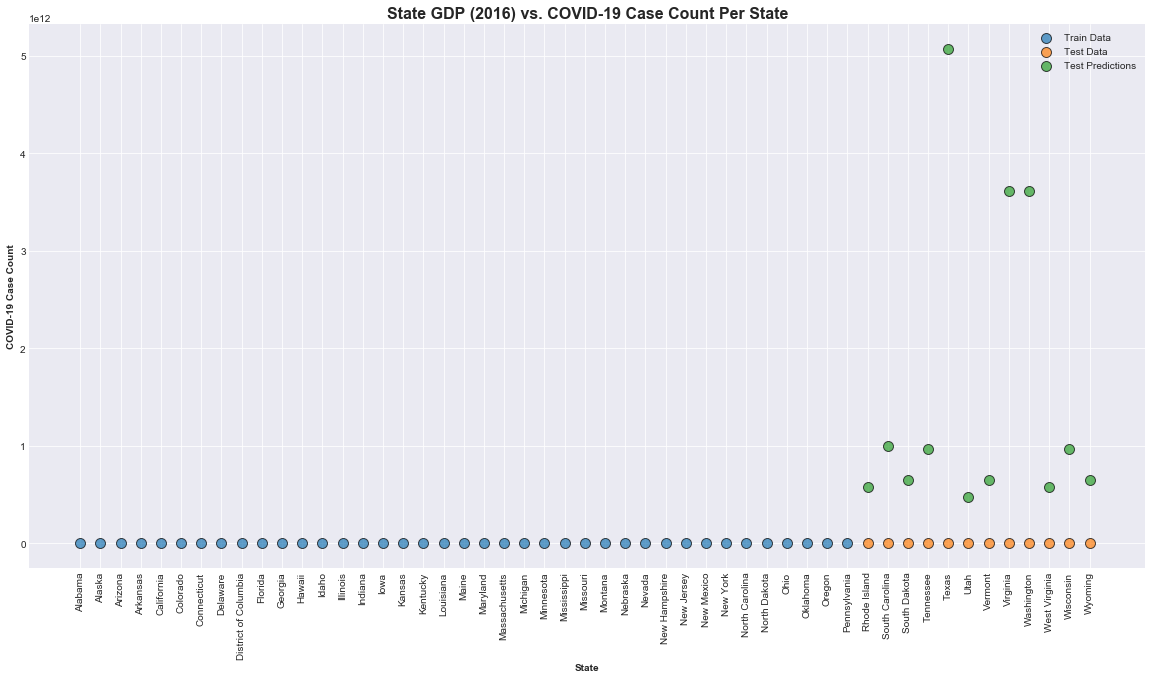

In [9]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('State GDP (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [10]:
features_list = ['School Expenditures per State GDP(Percent)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 2302492089395.0835
MSE Value: 5.30146982172712e+24
RMS Value: 2302492089395.123
R2 Score: -28833557016583.223


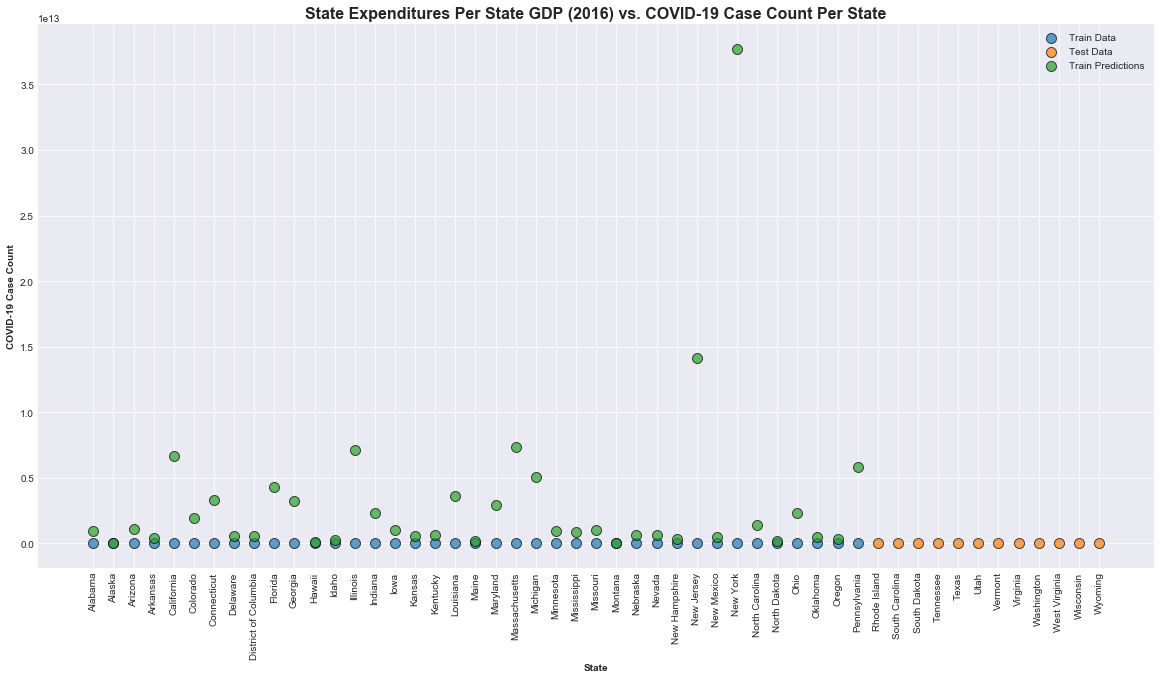

In [11]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('State Expenditures Per State GDP (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

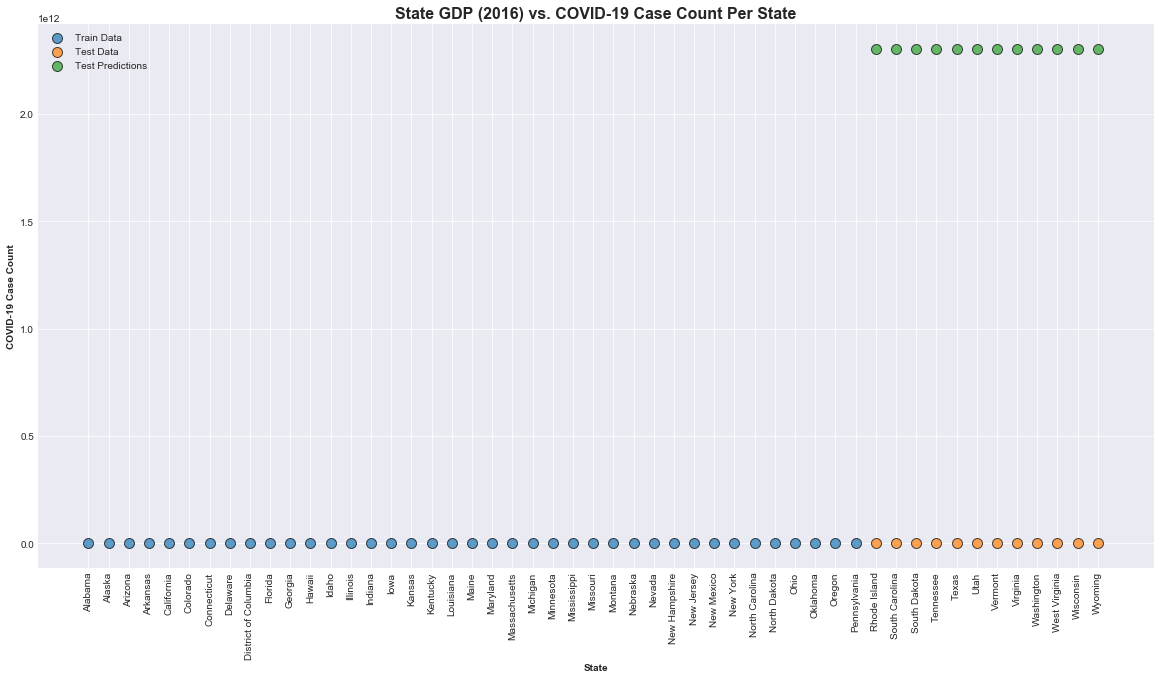

In [12]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('State GDP (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [13]:
features_list = ['Public School Expenditure 2016(Thousands)', 'State GDP(Millions)']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)



MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 13081940772573.75
MSE Value: 3.7597526356693065e+26
RMS Value: 19390081577108.71
R2 Score: -2044848799186538.0


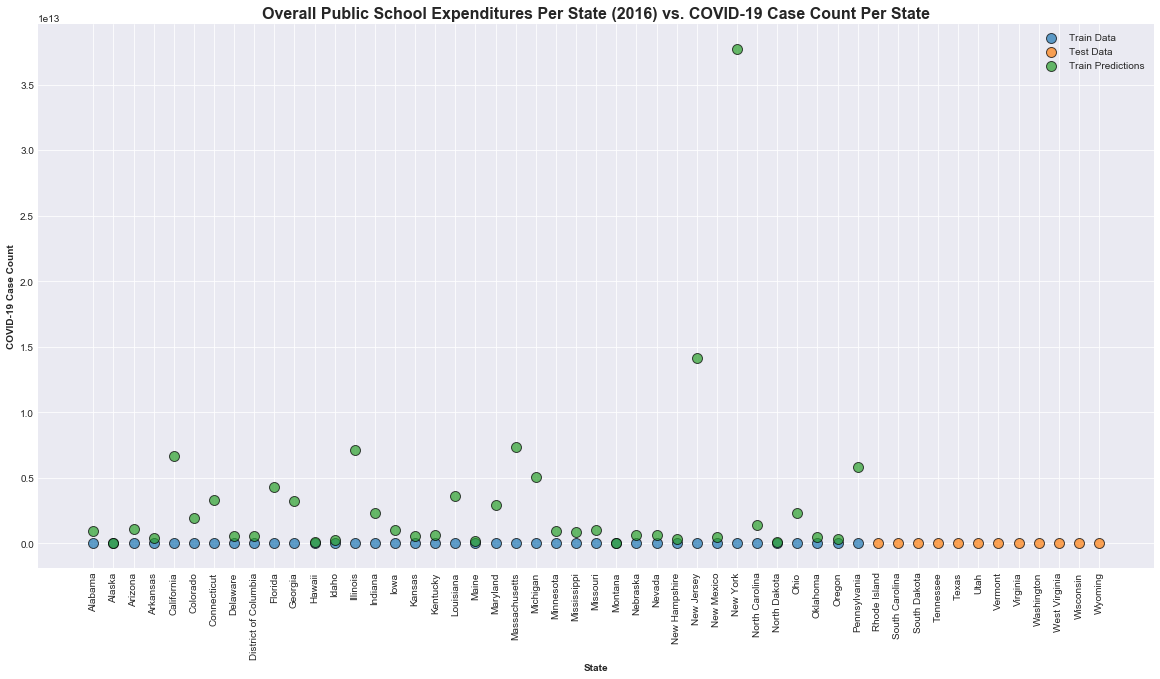

In [14]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Public School Expenditures Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

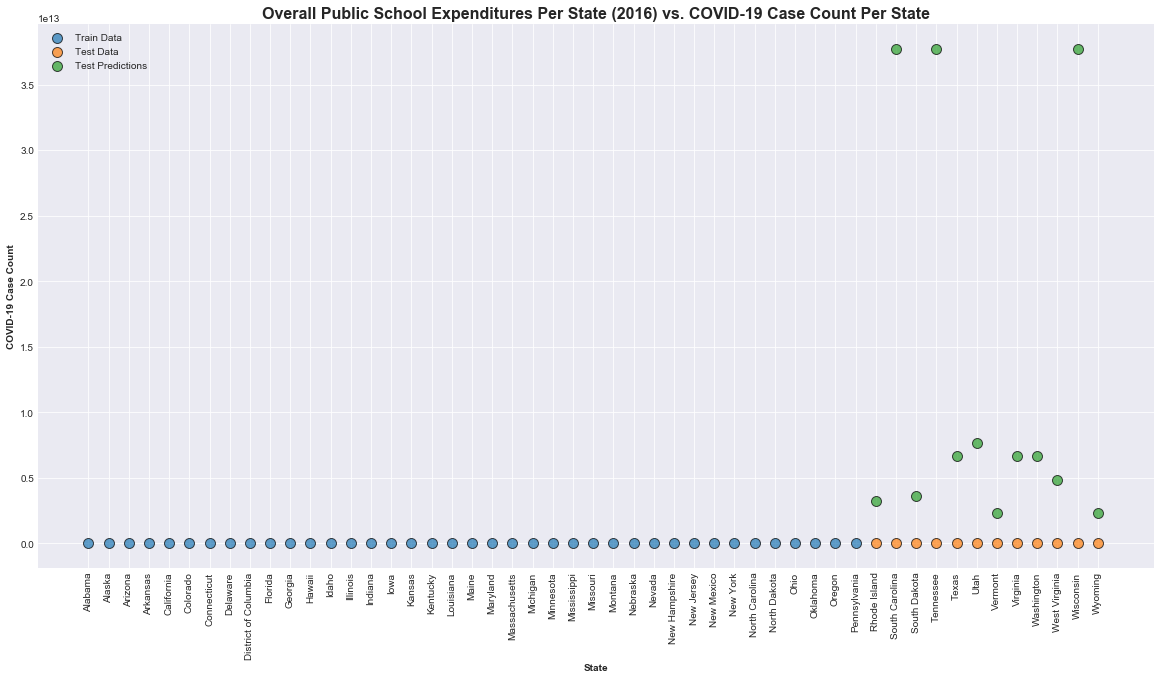

In [15]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Public School Expenditures Per State (2016) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();